# MCMC using backward filtering, forward guiding for shapes with SDE transitions

Parameter inference for trees with Kunita-like SDEs transitions along edges and observations at the leaf nodes for landmark represented shapes. Please refer to the notebooks [mcmc_Gaussian_BFFG.ipynb](mcmc_Gaussian_BFFG.ipynb), [mcmc_Gaussian_BFFG_shapes.ipynb](mcmc_Gaussian_BFFG_shapes.ipynb), [mcmc_Gaussian_BFFG_shapes_state-dependent_covariance.ipynb](mcmc_Gaussian_BFFG_shapes_state-dependent_covariance.ipynb) for simplified versions. The covariance of each stochastic step is shape dependent and the processes nonlinear, thus requiring computation of likelihood ratios in the downwards passes for use in the MCMC iterations.

The covariance is assumed rotationally invariant, allowing factorization into a kernel product the identity matrix of the ambient space.

The conditioning and upwards/downwards message passing and fusing operations follow the backward filtering, forward guiding approach of Frank van der Meulen, Moritz Schauer et al., see https://arxiv.org/abs/2010.03509 and https://arxiv.org/abs/2203.04155 . The latter reference provides an accesible introduction to the scheme and the notation used in this example.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
jax.config.update("jax_enable_x64", True)
from jax import numpy as jnp
from jax.random import PRNGKey, split

from hyperiax.tree.topology import symmetric_topology
from hyperiax.tree import HypTree

from hyperiax.plotting import plot_tree_text, plot_shape_2d, plot_tree_2d_scatter, plot_tree_2d_shape

from hyperiax.mcmc import ParameterStore, VarianceParameter
from hyperiax.mcmc.metropolis_hastings import metropolis_hastings
from hyperiax.mcmc.plotting import trace_plots

from examples.SDE import dot, solve
from examples.ABFFG import *
from examples.shape import k_K2

import matplotlib.pyplot as plt

In [3]:
# seed
#seed = 216298397259
import os; seed = int(os.urandom(5).hex(), 16)
print("seed: ",seed)
key = PRNGKey(seed)

seed:  930340285803


# Shape related setup

<Axes: >

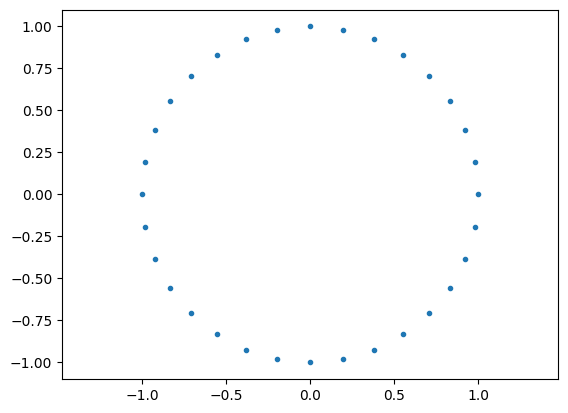

In [4]:
# define shape and plot
d = 2; n = 32 # d = dimension of embedding space (usually 2), n = number of landmarkds
phis = jnp.linspace(0,2*jnp.pi,n,endpoint=False) # circular shape
root = jnp.vstack((jnp.cos(phis),jnp.sin(phis))).T.flatten()

# plot
plot_shape = plot_shape_2d
plot_shape(root)

# SDE setup

In [5]:
n_steps = 500 # number of time steps in the discretization

 # drift
def b(t,x,params): return jnp.zeros(n*d)

# diffusion and covariance specification for shape processes
# assumes same covariance in all directions (x,y or x,y,z), thus allowing some factorization of the covariance matrix
kQ12 = lambda x,params: (.25/max(16,n))*k_K2(x,params)

# evaluate k on two pairs of landmark configurations
kQ12_q = lambda q1,q2,params: kQ12(q1.reshape((-1,d))[:,jnp.newaxis,:]-q2.reshape((-1,d))[jnp.newaxis,:,:],params)

# diffusion field and covariance matrix factored in dimensions
sigma = lambda q,theta: kQ12_q(q,q,theta) # diffusion field, kernel evaluated on all landmark pairs
def a(q,theta): sigmaq = sigma(q,theta); return jnp.einsum('ij,kj->ik',sigmaq,sigmaq) # covariance

# Tree with SDE transitions

First, we initialize the tree. We set the root to the shape defined above.

In [6]:
# create topology and tree
#degree = 2; topology = symmetric_topology(height=3, degree=degree)
degree = 5; topology = symmetric_topology(height=2, degree=degree)
plot_tree_text(topology)
tree = HypTree(topology)
print(tree)
n_leaves = tree.is_leaf.sum()

# add properties to tree
tree.add_property('edge_length', shape=())
n_edges = tree.data['edge_length'].shape[0]
tree.add_property('value', shape=(n_steps+1,n*d,))
tree.add_property('noise', shape=(n_steps,n*d))

# set edge lengths on all nodes
tree.data['edge_length'] = jnp.ones_like(tree.data['edge_length'])

# root value
tree.data['value'] = tree.data['value'].at[0].set(root)

                                                            None
           ┌────────────────────────┬────────────────────────┼────────────────────────┬────────────────────────┐
          None                     None                     None                     None                     None          
 ┌────┬────┼────┬────┐    ┌────┬────┼────┬────┐    ┌────┬────┼────┬────┐    ┌────┬────┼────┬────┐    ┌────┬────┼────┬────┐  
None None None None None None None None None None None None None None None None None None None None None None None None None
HypTree(size=31, levels=3, leaves=25, inner nodes=5)


We then define parameters for the Gaussian transition kernel.

In [7]:
# parameters, variance and observation noise
params = ParameterStore({
    'k_alpha': VarianceParameter(.3), # kernel amplitude, governs global tree variance
    'k_sigma': VarianceParameter(.25), # kernel width, for Gaussian kernels this is proportional to the variance
    'obs_var': VarianceParameter(1e-3) # observation noise variance
    })

Now follows the down transitions using the SDE functions above. The step covariance is square of the pairwise kernel evaluations in `sigma(params)` times the variance parameter times edge lengths.

In [8]:
# unconditional down
down_unconditional = SDE_down_unconditional(n_steps,b,sigma)

We can now draw noise and perform a downwards pass. This gives values at all nodes of the tree. Note that observation noise is not added to the leaves yet.

In [9]:
# sample new noise
subkey, key = split(key)
update_noise(tree,subkey)
down_unconditional.down(tree,params.values())

Add uncorrelated observation noise to leaves.



In [10]:
# add noise to leaf nodes
key, subkey = split(key)
add_leaf_noise(tree,key,params)
leaf_values = tree.data['value'][tree.is_leaf][:,-1]

Plot tree.

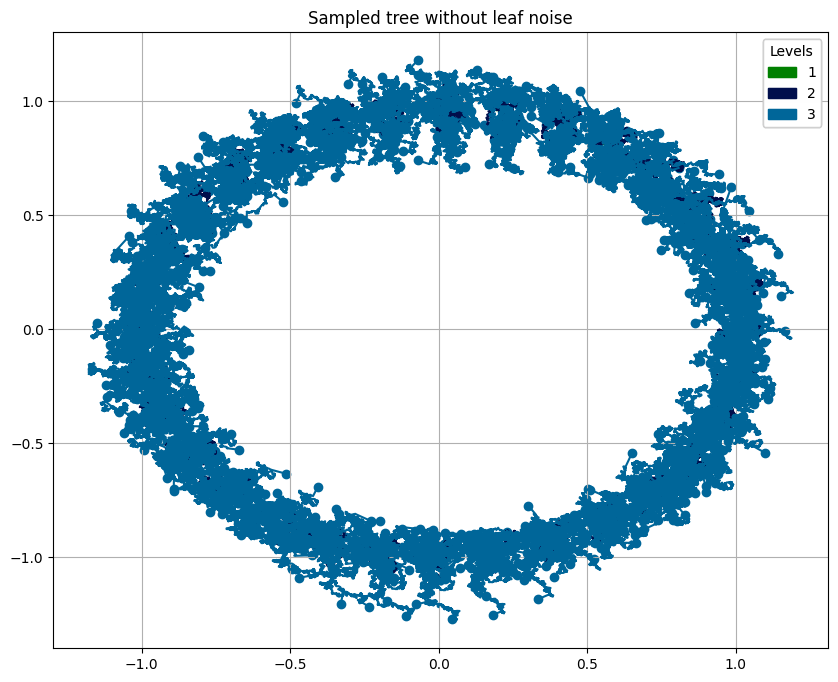

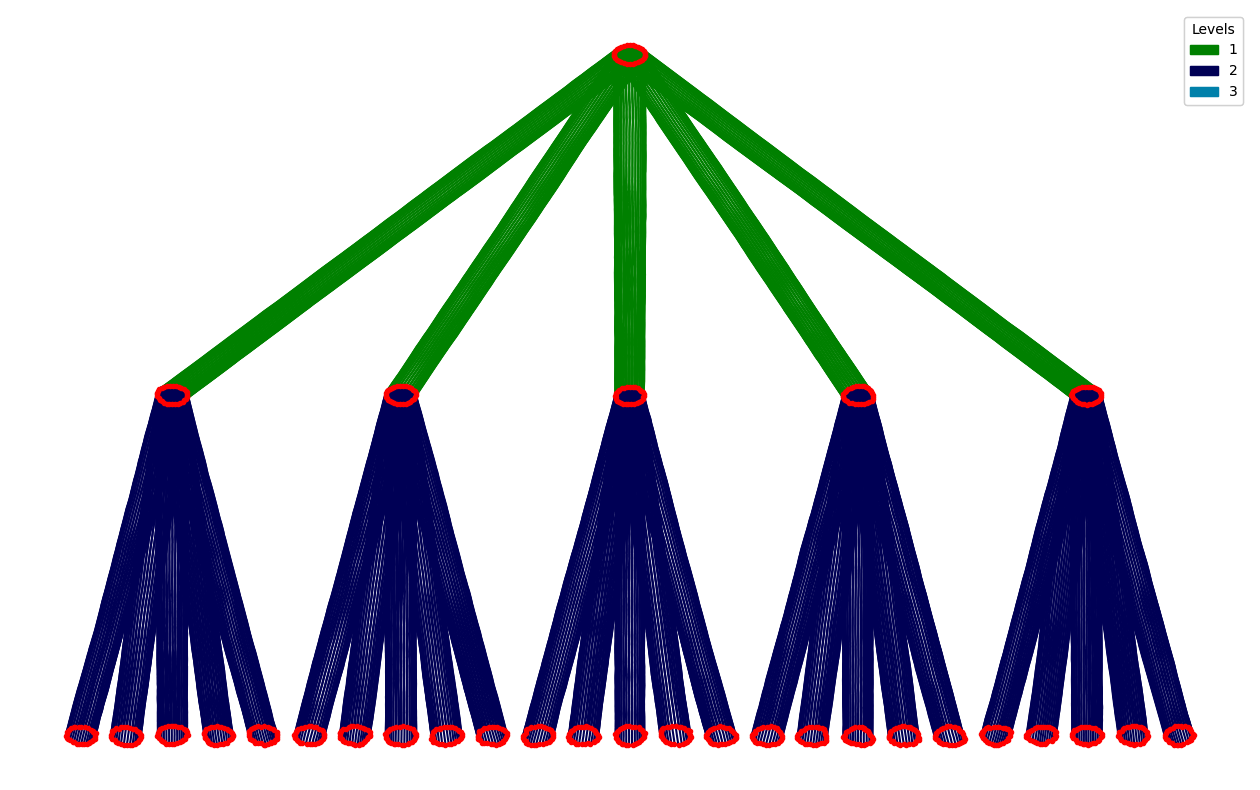

In [11]:
fig,ax = plt.subplots(figsize=(10,8))
plot_tree_2d_scatter(tree,'value',selector=lambda z: z.reshape((-1,n,d)),ax=ax)
plt.gca().set_title('Sampled tree without leaf noise')

plot_tree_2d_shape(tree,'value')

# Backwards filtering, forward guiding

We now define the backwards filter through the up function. The Gaussian are parametrized in the $(c,F,H)$ format make the fuse just a sum of the results of the up operation. See https://arxiv.org/abs/2203.04155 for details.

In [12]:
# backwards filter
up = SDE_up(n_steps,a)

We initialize the tree for up by computing the $c,F,H$-values at the leaves.

In [13]:
# initialize tree
init_up = get_init_up(n,tree,d=d,root=root,n_steps=n_steps)

We can now define the conditional downwards pass, i.e. the forwards guiding.

In [14]:
# conditional down
down_conditional = SDE_down_conditional(n_steps,b,sigma,a)

We make an upwards pass and a downwards conditional sampling to test. Subsequently, we time the three operations (uncondtional down, conditional down, and up).

In [15]:
# backwards filter and fowards guiding, time the operations
test_up_down(down_unconditional,down_conditional,up,init_up,tree,params,leaf_values,key)

Time elapsed: 608.2168 ms
Time elapsed: 729.1620 ms
Time elapsed: 1.8806 ms


We test the setup by sampling a number of trees and computing mean and covariance of the leaf data.

In [16]:
# do statistics on the leaf values
F = tree.data['F_T'][0]; H = tree.data['H_T'][0]
print("root conditional mean vs. sample mean:",solve(H,F),jnp.mean(leaf_values,0))
print("root conditional cov vs. sample cov:",jnp.linalg.inv(H),jnp.cov(leaf_values.T))

# sample statistics
K = 500 # number samples
samples = jnp.zeros((K,sum(tree.is_leaf),n*d))
samples_noise = jnp.zeros((K,sum(tree.is_leaf),n*d))
samples_conditional = jnp.zeros((K,sum(tree.is_leaf),n*d))

from tqdm import tqdm
for i in tqdm(range(K)):
    subkey, key = split(key)
    update_noise(tree,subkey)
    down_unconditional.down(tree,params.values())
    values = tree.data['value'][tree.is_leaf][:,-1]
    # collect values
    samples = samples.at[i].set(values)
    # add observation noise
    subkey,key = jax.random.split(key)
    samples_noise = samples_noise.at[i].set(values+jnp.sqrt(params['obs_var'].value)*jax.random.normal(subkey,values.shape))
    # conditional sampling
    update_noise(tree,subkey)
    down_conditional.down(tree,params.values())
    samples_conditional = samples_conditional.at[i].set(tree.data['value'][tree.is_leaf][:,-1])
# print sample statistics for all leaves
print("data parameters: ",params.values())
print("observation noise: ")
print(" mean: ",jnp.mean(samples_conditional-leaf_values,axis=(0,1)))
print(" diag cov: ",jnp.diag(jnp.cov((samples_conditional-leaf_values).reshape(-1,n*d).T)))
print("leaves: ")
for i in range(samples.shape[1]):
    #print("  mean: ",jnp.mean(samples[:,i],0))
    #print("  cov: ",jnp.cov(samples[:,i].T))
    #print("  mean w/ noise: ",jnp.mean(samples_noise[:,i],0))
    #print("  diag cov w/ noise: ",jnp.cov(jnp.cov(samples_noise[:,i].T)))
    #print("  mean conditional: ",jnp.mean(samples_conditional[:,i],0), ", sample: ",leaf_values[i])
    #print("  diag cov conditional: ",jnp.diag(jnp.cov(samples_conditional[:,i].T)))
    print("  mean noise: ",jnp.mean(samples_conditional[:,i]-leaf_values[i],0))
    print("  diag cov noise: ",jnp.diag(jnp.cov((samples_conditional[:,i]-leaf_values[i]).T)))

root conditional mean vs. sample mean: [ 1.00713645 -0.05534327  0.98561978  0.14689238  0.92424062  0.33710508
  0.83315716  0.51148111  0.71445553  0.63438758  0.58330583  0.76405804
  0.41105061  0.84940921  0.23387425  0.89446458  0.04696486  0.92465888
 -0.14650157  0.90953996 -0.34883744  0.84964066 -0.50679215  0.76531145
 -0.674321    0.66541953 -0.81032919  0.50977312 -0.89602973  0.33827324
 -0.95522262  0.18162574 -0.98490461 -0.00803711 -0.97003397 -0.19991498
 -0.91230366 -0.37238784 -0.79168459 -0.54907272 -0.68196774 -0.70454092
 -0.54497527 -0.82660789 -0.37996648 -0.90652162 -0.19588249 -0.95251183
 -0.01784149 -0.98165255  0.1774614  -0.98281354  0.35338947 -0.92824154
  0.5337667  -0.83752173  0.68686386 -0.7422518   0.80964464 -0.60955354
  0.90152508 -0.43664134  0.97856969 -0.25654648] [ 1.03313423 -0.05974029  1.0093593   0.14642479  0.94571168  0.34006895
  0.85213087  0.51778807  0.72975537  0.64432106  0.59327972  0.77689359
  0.41635577  0.86537801  0.2346903

100%|██████████| 500/500 [06:08<00:00,  1.36it/s]


data parameters:  {'k_alpha': 0.3, 'k_sigma': 0.25, 'obs_var': 0.001}
observation noise: 
 mean:  [-9.54808667e-03  1.23267160e-03 -4.14152330e-03 -1.80216927e-03
  1.28181564e-03 -3.31604848e-03  2.21155366e-03 -9.45282977e-03
  2.49999951e-03  1.04019735e-02 -8.05574131e-03 -3.47278806e-03
  1.48385569e-03 -3.73518821e-03  2.12065522e-04  5.65888699e-03
 -2.36984953e-03 -5.19803310e-03 -2.19699785e-03 -5.23985527e-03
  1.04771594e-02  2.65132878e-03 -8.47887865e-03  2.46808918e-03
  2.17432132e-03 -1.35211687e-02  9.04650024e-03  1.15650472e-03
 -3.22415111e-03  1.16957022e-02 -4.55645704e-03 -7.37991972e-03
  3.51613972e-03 -1.26871322e-03  8.38878683e-03  4.63111515e-03
  1.09414484e-02 -5.91226378e-03 -1.41259829e-02  3.75007734e-04
 -1.65962407e-03  6.22612079e-03  6.19727022e-03  7.68818508e-03
  4.92404456e-03  7.79024230e-05 -3.30249369e-03 -8.13160848e-03
  4.01194403e-03  9.63214960e-05 -3.48055506e-03  1.25433755e-02
  4.31467799e-03  3.16366123e-03 -4.50845377e-03 -1.02194

# MCMC

MCMC run incorporating the likelihood ratios arising from the Gaussian approximation.

Initial parameters:  {'k_alpha': 0.5, 'k_sigma': 0.5, 'obs_var': 0.005}
data parameters:  {'k_alpha': 0.3, 'k_sigma': 0.25, 'obs_var': 0.001}


100%|██████████| 2000/2000 [24:36<00:00,  1.35it/s]

Acceptance rate: 0.4980


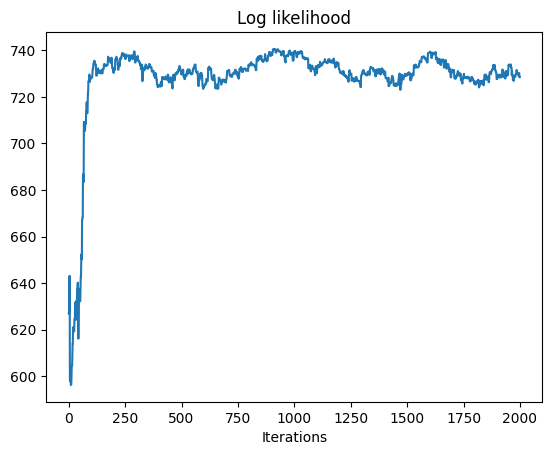

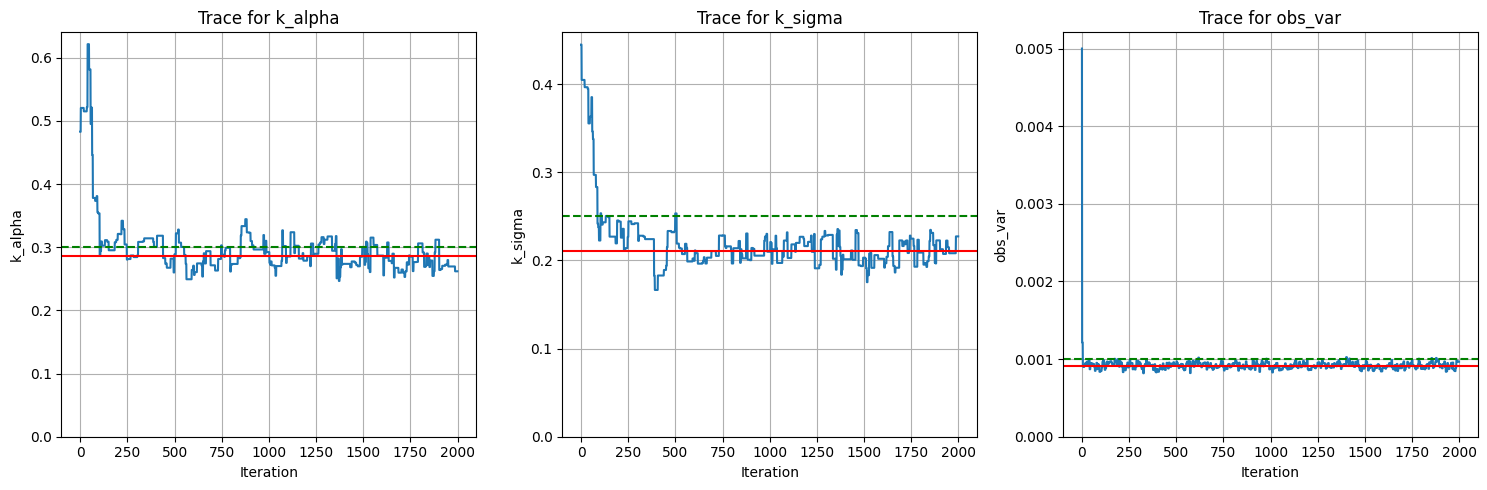

In [17]:
log_likelihood = get_log_likelihood(tree,down_conditional,up,init_up)
obs_var_sample_conditional = True
log_posterior = get_log_posterior(log_likelihood,skip_obs_var=obs_var_sample_conditional)
proposal = get_proposal(tree,obs_var_sample_conditional=obs_var_sample_conditional)

# tree values and parameters
init_params = ParameterStore({
    'k_alpha': VarianceParameter(.5,alpha=2.,beta=.5), # kernel amplitude, governs global tree variance
    'k_sigma': VarianceParameter(.5), # kernel width, for Gaussian kernels this is proportional to the variance
    #'obs_var': VarianceParameter(.5*1e-3,min=1e-4,max=.1,prior='uniform'), # observation noise variance
    'obs_var': VarianceParameter(5*1e-3,alpha=2,beta=.005,min=1e-4,keep_constant=False), # observation noise variance
    })
print("Initial parameters: ",init_params.values())
print("data parameters: ",params.values())

# initial state
init_state = (init_params,(jnp.zeros_like(tree.data['noise']),tree.data['v_T']))

# Run Metropolis-Hastings
subkey, key = split(key)
log_likelihoods, samples = metropolis_hastings(log_posterior, proposal, leaf_values, init_state, 2000, burn_in=000, rng_key=key, savef=lambda state: state[0])

# plot
burnin = 500
plt.plot(log_likelihoods)
plt.xlabel("Iterations")
plt.title('Log likelihood')
trace_plots(samples,params.values(),burnin=burnin)
None

In [18]:
## plot v_0, v_T by level from leaves up (excluding root)
#for level_num, level in enumerate(tree.levels[1:]):  # Skip root level
#    print(f"Level {level_num+1}")
#    for i in range(*level):
#        print(tree.data['logpsi'][i])
#        ax = plot_shape(tree.data['v_0'][i],color='blue',label='v_0')
#        plot_shape(tree.data['v_T'][i],color='red',label='v_T',ax=ax)
#        ax.set_aspect('auto')
#        ax.axis([-1.5,1.5,-1.5,1.5])
#        plt.legend()
#        plt.show()

/Users/stefan/projects/hyperiax/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 61719 instead
  warnings.warn(


Number of workers: 10
Cores per worker: {'tcp://127.0.0.1:61743': 2, 'tcp://127.0.0.1:61746': 2, 'tcp://127.0.0.1:61749': 2, 'tcp://127.0.0.1:61752': 2, 'tcp://127.0.0.1:61755': 2, 'tcp://127.0.0.1:61758': 2, 'tcp://127.0.0.1:61761': 2, 'tcp://127.0.0.1:61764': 2, 'tcp://127.0.0.1:61767': 2, 'tcp://127.0.0.1:61770': 2}


/Users/stefan/projects/hyperiax/lib/python3.10/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 15.73 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


k_alpha - mean: 0.2913, median: 0.2871
k_sigma - mean: 0.2445, median: 0.2441
obs_var - mean: 0.0010, median: 0.0010


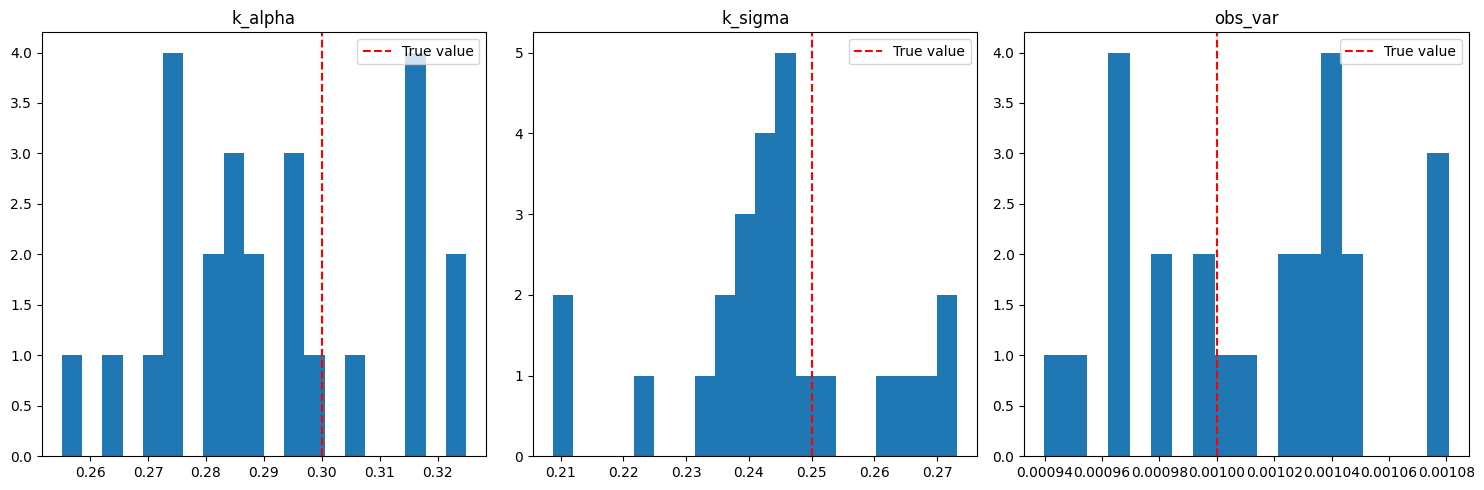

In [19]:
import dask
from dask.distributed import Client, LocalCluster

# Set up dask client for parallel processing
# Using 10 workers as a balanced choice for M3
cluster = LocalCluster(n_workers=10)  # Use 10 workers to mainly utilize P cores
client = Client(cluster)
# Get number of workers and threads
print(f"Number of workers: {len(client.ncores())}")
print(f"Cores per worker: {client.ncores()}")

# Number of parallel chains
K = 25

# Function to run single MCMC chain
def run_mcmc_chain(seed):
    key = jax.random.PRNGKey(seed)

    # sample leaf values
    subkey, key = split(key)
    update_noise(tree,subkey)
    down_unconditional.down(tree,params.values())

    # add noise to leaf nodes
    key, subkey = split(key)
    leaf_values = tree.data['value'][tree.is_leaf,-1]+jnp.sqrt(params['obs_var'].value)*jax.random.normal(subkey,tree.data['value'][tree.is_leaf,-1].shape)

    # mcmc
    subkey, key = split(key)
    init_state = (init_params,(jnp.zeros_like(tree.data['noise']),tree.data['v_T']))
    log_likes, chain_samples = metropolis_hastings(log_posterior, proposal, leaf_values, 
                                                 init_state, 500, burn_in=2000, 
                                                 rng_key=key, savef=lambda state: state[0],
                                                 verbose=False)
    # Get mean of samples for each parameter
    means = {k: jnp.mean(jnp.array([s[k].value for s in chain_samples])) for k in chain_samples[0].values().keys()}
    return means

# Run chains in parallel
futures = [dask.delayed(run_mcmc_chain)(i) for i in range(K)]
results = dask.compute(*futures)

# Convert results to parameter arrays
k_alpha_means = jnp.array([r['k_alpha'] for r in results])
k_sigma_means = jnp.array([r['k_sigma'] for r in results])
obs_var_means = jnp.array([r['obs_var'] for r in results])

print(f"k_alpha - mean: {jnp.mean(k_alpha_means):.4f}, median: {jnp.median(k_alpha_means):.4f}")
print(f"k_sigma - mean: {jnp.mean(k_sigma_means):.4f}, median: {jnp.median(k_sigma_means):.4f}")
print(f"obs_var - mean: {jnp.mean(obs_var_means):.4f}, median: {jnp.median(obs_var_means):.4f}")

# Plot histograms
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))

ax1.hist(k_alpha_means,bins=20)
ax1.axvline(params['k_alpha'].value,color='r',linestyle='--',label='True value')
ax1.set_title('k_alpha')
ax1.legend()

ax2.hist(k_sigma_means,bins=20)
ax2.axvline(params['k_sigma'].value,color='r',linestyle='--',label='True value')
ax2.set_title('k_sigma')
ax2.legend()

ax3.hist(obs_var_means,bins=jnp.linspace(min(obs_var_means),max(obs_var_means),20))
ax3.axvline(params['obs_var'].value,color='r',linestyle='--',label='True value')
ax3.set_title('obs_var')
ax3.legend()

plt.tight_layout()

# Clean up dask client
client.close()
cluster.close()


Prior is maximized at x = 0.16245454545454546
Prior is maximized at x = 0.4954545454545455
Prior is maximized at x = 0.001673737373737374


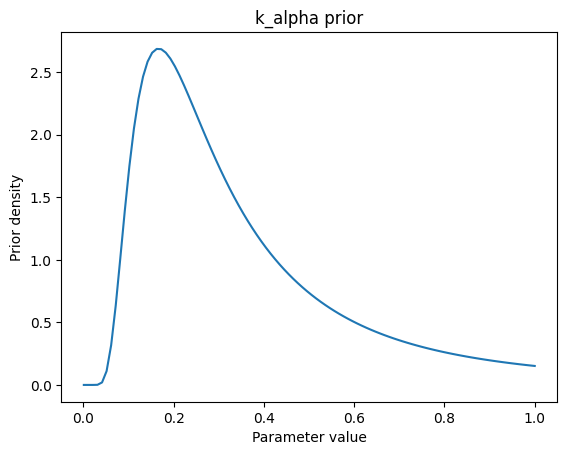

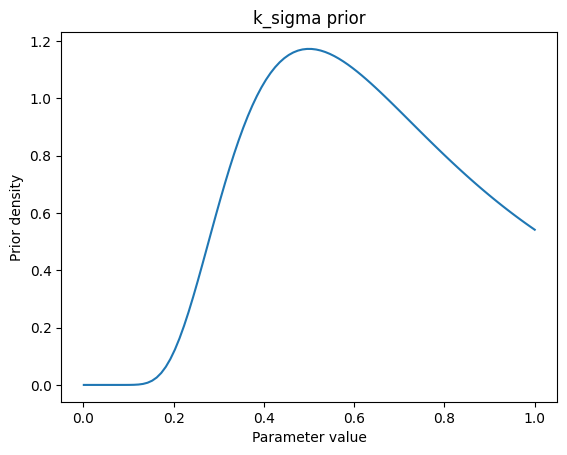

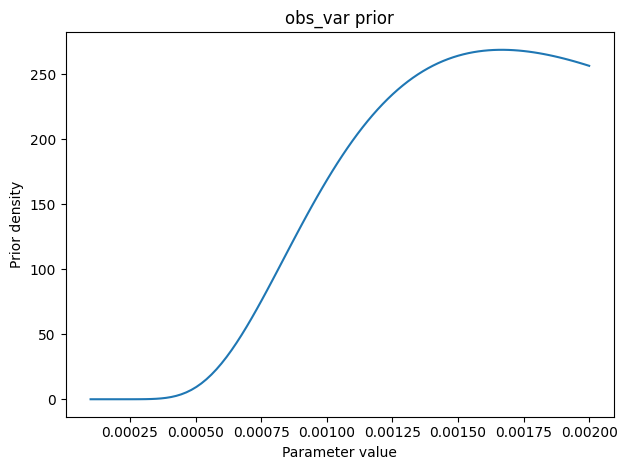

In [20]:
# Plot priors for all initial parameters
init_params['k_alpha'].plot_prior()
plt.title('k_alpha prior')

init_params['k_sigma'].plot_prior()
plt.title('k_sigma prior')

init_params['obs_var'].plot_prior(x_min=1e-4,x_max=2*1e-3)
plt.title('obs_var prior')

plt.tight_layout()